In [1]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageOps,ImageFilter
import keras
from keras import layers
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential
import tensorflow as tf
import cv2

### View Image

In [2]:
image = PIL.Image.open("Dataset/images/trainA/ct15.png")
image = image.resize((100,100))
image_array = np.asarray(image)
image_array.shape,type(image_array)


((100, 100), numpy.ndarray)

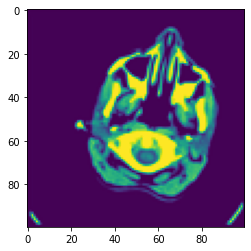

In [3]:
plt.imshow(image_array)
plt.show()

In [4]:
import PIL
import os
from PIL import Image,ImageOps
import numpy as np
image = Image.open("Dataset/images/trainB/mri1.jpg") 
image = ImageOps.grayscale(image)
image = image.filter(ImageFilter.SHARPEN)
image = image.resize((100,100))
image_array = np.asarray(image)
image_array.shape,type(image_array)

((100, 100), numpy.ndarray)

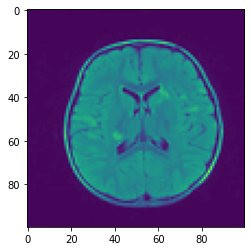

In [5]:
plt.imshow(image_array)
plt.show()

### Image Preprocess

In [6]:
def load_ct_from_folder(folder,n=800):
    images = []
    for filename in os.listdir(folder)[:n]:
        image = PIL.Image.open(os.path.join(folder,filename))
        image = image.resize((276,276))
        image_array = np.asarray(image)
        if image is not None:
            images.append(image_array)
    return np.array(images,dtype=float)

def load_mri_from_folder(folder,n=800):
    images = []
    for filename in os.listdir(folder)[:n]:
        image = Image.open(os.path.join(folder,filename))
        image = ImageOps.grayscale(image)
        image = image.resize((276,276))
        image_array = np.asarray(image)
        if image is not None:
            images.append(image_array)
    return np.array(images,dtype=float)

In [7]:
def hist_match(asli, referensi):
    
    asli_shape = asli.shape
    
    asli = asli.ravel()
    referensi = referensi.ravel()

    o_values, bin_idx, o_counts = np.unique(asli, return_inverse=True,return_counts=True)
    b_values, b_counts = np.unique(referensi, return_counts=True)

    o_quantiles = np.cumsum(o_counts).astype(np.float64)
    o_quantiles /= o_quantiles[-1]
    b_quantiles = np.cumsum(b_counts).astype(np.float64)
    b_quantiles /= b_quantiles[-1]

    interp_t_values = np.interp(o_quantiles, b_quantiles, b_values)

    return interp_t_values[bin_idx].reshape(asli_shape)



def histogram_matching(original,reference):
    asli = cv2.imread(original)
    equ = np.copy(asli)
    for i  in range (3) :
        equ[:,:,i] = cv2.equalizeHist(asli[:,:,i])
    referensi =  cv2.imread(reference)
    hasilmatch = np.copy(asli)
    hasilmatch[:,:,1] = hist_match(asli[:,:,1], referensi[:,:,1])
    return hasilmatch


In [8]:
x_train_A = load_ct_from_folder("Dataset/images/trainA")

In [9]:
x_train_A.shape

(800, 276, 276)

In [10]:
x_train_B = load_mri_from_folder("Dataset/images/trainB")

In [11]:
x_train_B.shape

(800, 276, 276)

In [12]:
x_test_A = load_ct_from_folder("Dataset/images/testA")

In [13]:
x_test_A.shape

(744, 276, 276)

In [14]:
x_test_B = load_mri_from_folder("Dataset/images/testB")

In [15]:
x_test_B.shape

(744, 276, 276)

In [16]:
np.save("x_train_A.npy",x_train_A)
np.save("x_train_B.npy",x_train_B)
np.save("x_test_A.npy",x_test_A)
np.save("x_test_B.npy",x_test_B)

In [17]:
x_train_A = x_train_A / 255.
x_train_B = x_train_B / 255.
x_test_A = x_test_A / 255.
x_test_B = x_test_B / 255.

In [18]:
x_train_A.shape,x_train_B.shape,x_test_A.shape,x_test_B.shape

((800, 276, 276), (800, 276, 276), (744, 276, 276), (744, 276, 276))

In [19]:
x_train_a = np.reshape(x_train_A, newshape=(x_train_A.shape[0], np.prod(x_train_A.shape[1:])))
x_train_b = np.reshape(x_train_B, newshape=(x_train_B.shape[0], np.prod(x_train_B.shape[1:])))
x_test_a = np.reshape(x_test_A, newshape=(x_test_A.shape[0], np.prod(x_test_A.shape[1:])))
x_test_b = np.reshape(x_test_B, newshape=(x_test_B.shape[0], np.prod(x_test_B.shape[1:])))

In [20]:
x_train_a.shape,x_train_b.shape,x_test_a.shape,x_test_b.shape

((800, 76176), (800, 76176), (744, 76176), (744, 76176))

### Designing the convolutional autoencoder

In [21]:
input_img = keras.Input(shape=(276, 276, 1))
print(input_img.shape)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(None, 276, 276, 1)
(None, 276, 276, 16)
(None, 138, 138, 16)
(None, 138, 138, 8)
(None, 69, 69, 8)
(None, 69, 69, 8)
(None, 35, 35, 8)
(None, 35, 35, 8)
(None, 70, 70, 8)
(None, 70, 70, 8)
(None, 140, 140, 8)
(None, 138, 138, 16)
(None, 276, 276, 16)
KerasTensor(type_spec=TensorSpec(shape=(None, 276, 276, 1), dtype=tf.float32, name=None), name='conv2d_6/Sigmoid:0', description="created by layer 'conv2d_6'")


### Designing the deep autoencoder

In [22]:
import tensorflow.keras.layers
import tensorflow.keras.models

x = tensorflow.keras.layers.Input(shape=(76176), name="encoder_input")
encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=10000, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)
encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=5000, name="encoder_dense_2")(encoder_activ_layer1)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_2")(encoder_dense_layer2)
encoder_dense_layer3 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_3")(encoder_activ_layer2)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_3")(encoder_dense_layer2)
encoder_dense_layer4 = tensorflow.keras.layers.Dense(units=2, name="encoder_dense_4")(encoder_dense_layer3)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer4)
encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

decoder_input = tensorflow.keras.layers.Input(shape=(2), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)
decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=5000, name="decoder_dense_2")(decoder_activ_layer1)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_dense_layer2)
decoder_dense_layer3 = tensorflow.keras.layers.Dense(units=10000, name="decoder_dense_3")(decoder_activ_layer2)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_dense_layer3)
decoder_dense_layer4 = tensorflow.keras.layers.Dense(units=76176, name="decoder_dense_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer4)
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

ae_input = tensorflow.keras.layers.Input(shape=(76176), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)
ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")

import tensorflow.keras.optimizers  
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

/opt/homebrew/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
ae.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 76176)]           0         
                                                                 
 encoder_model (Functional)  (None, 2)                 813275902 
                                                                 
 decoder_model (Functional)  (None, 76176)             813352076 
                                                                 
Total params: 1,626,627,978
Trainable params: 1,626,627,978
Non-trainable params: 0
_________________________________________________________________


### Training the autoencoder

In [24]:
history = autoencoder.fit(x_train_B, x_train_A,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_B, x_test_A))

2022-03-30 14:19:18.941731: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
7/7 [==============================] - 33s 5s/step - loss: 0.6886 - val_loss: 0.6773
Epoch 2/10
7/7 [==============================] - 30s 4s/step - loss: 0.6626 - val_loss: 0.6270
Epoch 3/10
7/7 [==============================] - 33s 5s/step - loss: 0.6067 - val_loss: 0.5906
Epoch 4/10
7/7 [==============================] - 31s 4s/step - loss: 0.5716 - val_loss: 0.5355
Epoch 5/10
7/7 [==============================] - 31s 4s/step - loss: 0.5102 - val_loss: 0.4639
Epoch 6/10
7/7 [==============================] - 30s 4s/step - loss: 0.4457 - val_loss: 0.4283
Epoch 7/10
7/7 [==============================] - 30s 4s/step - loss: 0.4261 - val_loss: 0.4265
Epoch 8/10
7/7 [==============================] - 35s 5s/step - loss: 0.4237 - val_loss: 0.4222
Epoch 9/10
7/7 [==============================] - 39s 6s/step - loss: 0.4195 - val_loss: 0.4193
Epoch 10/10
7/7 [==============================] - 45s 7s/step - loss: 0.4174 - val_loss: 0.4186


In [25]:
ae.fit(x_train_a, x_train_b, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test_a, x_test_b))

Epoch 1/20
4/4 [==============================] - 886s 273s/step - loss: 1.5620 - val_loss: 10.5176
Epoch 2/20
4/4 [==============================] - 988s 262s/step - loss: 15.0380 - val_loss: 7.2483
Epoch 3/20
4/4 [==============================] - 967s 263s/step - loss: 7.5461 - val_loss: 11.4220
Epoch 4/20
4/4 [==============================] - 1097s 291s/step - loss: 8.6548 - val_loss: 16.9955
Epoch 5/20
4/4 [==============================] - 977s 246s/step - loss: 11.4720 - val_loss: 0.7859
Epoch 6/20
4/4 [==============================] - 995s 258s/step - loss: 16.7394 - val_loss: 34.3003
Epoch 7/20
4/4 [==============================] - 1027s 266s/step - loss: 79.6632 - val_loss: 41.5096
Epoch 8/20
4/4 [==============================] - 815s 212s/step - loss: 14.0684 - val_loss: 5.9887
Epoch 9/20
4/4 [==============================] - 852s 219s/step - loss: 5.9156 - val_loss: 2.8105
Epoch 10/20
4/4 [==============================] - 816s 221s/step - loss: 2.8165 - val_loss: 1.10

### Testing the trained model and comparing it with the original data

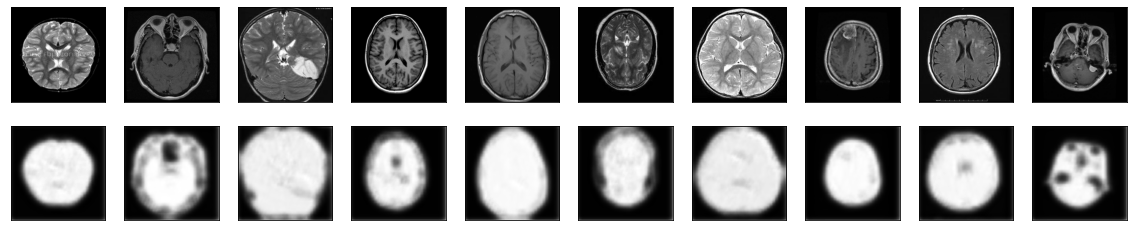

In [26]:
decoded_imgs = autoencoder.predict(x_test_B)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_B[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
unseen = load_ct_from_folder("Dataset/unseen_demo_images/ct")

In [28]:
unseen_ct_imgs = autoencoder.predict(unseen)

In [29]:
unseen_ct_imgs.shape

(15, 276, 276, 1)

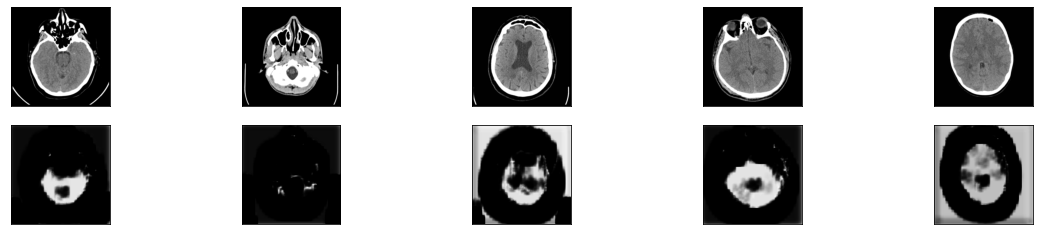

In [30]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(unseen[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(unseen_ct_imgs[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Visualising the states of a image through the autoencoder

In [35]:
#encoder model
model=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),activation ='relu', input_shape=(276,276,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(8,(3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(8,(3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),   
 ])

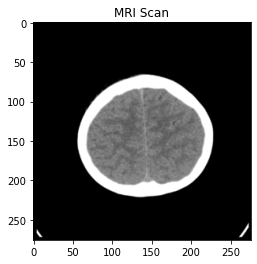

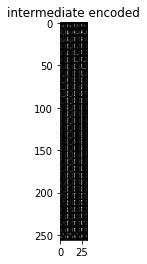

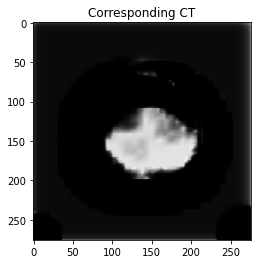

In [36]:
def visualize(img,encoder):
    code = encoder.predict(img[None])[0]
    
    # Display original
    plt.title("MRI Scan")
    plt.imshow(unseen[0].reshape(276, 276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    #Display compressed
    plt.subplot(1,3,2)
    plt.title("intermediate encoded")
    plt.imshow(code.reshape([code.shape[-1]//32,-1]))
    plt.show()

    # Display reconstruction
    plt.title("Corresponding CT")
    plt.imshow(unseen_ct_imgs[0].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

visualize(x_test_B[0],model)

### Analysing the loss wrt epoch

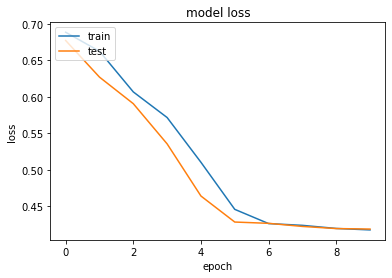

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

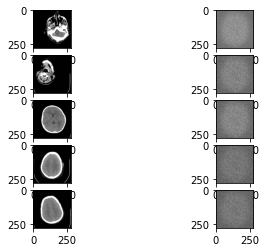

<Figure size 432x288 with 0 Axes>

In [38]:
encoded_images = encoder.predict(x_test_a)
decoded_images = decoder.predict(encoded_images)
decoded_images_orig = np.reshape(decoded_images, newshape=(decoded_images.shape[0], 276,276))

num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_test_A.shape[0])
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(x_test_A[rand_ind, :, :], cmap="gray")
    plt.subplot(num_images_to_show, 2, plot_ind+1)
    plt.imshow(decoded_images_orig[rand_ind, :, :], cmap="gray")
plt.figure()
